In [4]:
! pip install tqdm -q
! pip install -U matplotlib -q
! pip install scikit-image -q
! pip install opencv-python -q


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [1]:
import torch
import os
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage
from torch.utils.data import DataLoader
from torchvision import transforms
from utils import *
from model import ColorizationCNN
%reload_ext autoreload
%autoreload 2

In [2]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [22]:
# Define hyperparameters
batch_size = 32
learning_rate = .1
num_epochs = 10

num_channels_in = 1
num_channels_out = 2
im_size = 256

In [23]:
# Load images

def getDataLoader(img_root):
    imgfolder = ImageFolder(root=img_root, transform=transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize((256,256), antialias=True),
    ]))
    img_dataloader = DataLoader(imgfolder, batch_size = 32)
    return img_dataloader

img_train_loader = getDataLoader("small_data/colorimage")
img_test_loader = getDataLoader("small_data/colorimage")

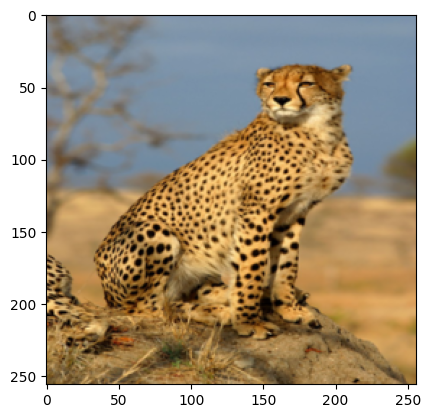

In [24]:
#Print first image of trainloader
x, _ = next(iter(img_train_loader))
img = np.zeros((256,256,3))
img[:,:,0] = x[0,0,:,:]
img[:,:,1] = x[0,1,:,:]
img[:,:,2] = x[0,2,:,:]
plt.imshow(img)

In [25]:
#Initialization
from model import ColorizationCNN
net = None
net = ColorizationCNN().to(device)
if device == torch.device("cuda"):
    net = nn.DataParallel(net).cuda()
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
criterion = nn.MSELoss(reduction='mean')


In [26]:
#Training
from train import train
train(net, optimizer, criterion, img_train_loader, num_epochs, device)

EPOCH: 1
Cumulative loss of epoch= 459.2896423339844
EPOCH: 2
Cumulative loss of epoch= 444.45477294921875
EPOCH: 3
Cumulative loss of epoch= 494.3418884277344
EPOCH: 4
Cumulative loss of epoch= 423.69757080078125
EPOCH: 5
Cumulative loss of epoch= 437.2784118652344
EPOCH: 6
Cumulative loss of epoch= 421.62017822265625
EPOCH: 7
Cumulative loss of epoch= 366.4464416503906
EPOCH: 8
Cumulative loss of epoch= 419.3204345703125
EPOCH: 9
Cumulative loss of epoch= 394.1363525390625
EPOCH: 10
Cumulative loss of epoch= 390.2454833984375


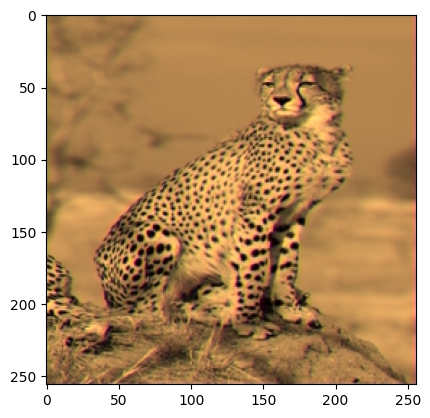

In [27]:
# naive evaluation
'''
    Model tends to turn grey on higher evaluation
    L2 is very bad because it's basically treating the entire batch as one image, and the entire image as a single entity
    Need to implement something that considers spatial trends before submitting project
'''

from utils import *
net.eval()
with torch.no_grad():
    x, _ = next(iter(img_test_loader))
    x = x[0] # get first rgb image
    x_out = rgb_to_output(net, x)[0]
    x_lab = rgb2lab_skimage(x)
    x_lab[1] = x_out[0]
    x_lab[2] = x_out[1]
    x_out_rgb = lab2rgb_skimage(x_lab).permute(1,2,0)
    plt.figure()
    plt.imshow(x_out_rgb)
    plt.show()

In [ ]:
#porting origional evaulation

import torchvision.models as models

test_dataset = []

net.eval() 
output_imgs = []
vgg = models.vgg19(pretrained=True).eval()
current_correct = 0
current_total = 0
correct_fake = 0
total = 0
best_accuracy = 0
best_idx = 0
with torch.no_grad():
        for i,sample in enumerate(test_dataset):
            grey = sample['input']
            color = sample['output']
            colorized_images = net.forward(grey)

            # colorized_images = colorized_images.unsqueeze(0)
            # #print(colorized_images.shape)
            # colorized_images = colorized_images.permute(0, 3, 2, 1)
            # #print(colorized_images.shape)
            colorized_images = np.stack((grey, (colorized_images[:,:,0]).detach().numpy() * 255, (colorized_images[:,:,1]).detach().numpy() * 255), axis=-1)
            

            colorized_images = torch.tensor(colorized_images).float().unsqueeze(0)
            colorized_images = colorized_images.permute(0, 3, 2, 1)
            #print(colorized_images.shape)

            color = torch.tensor(color).float().unsqueeze(0)
            color = color.permute(0, 3, 2, 1)
            #print(color.shape)
            outputs_fake = vgg(colorized_images) #run our fake colorized images thru VGG and see the scores
            outputs_real = vgg(color) #get the real labels using the output

            _, predicted_fake = torch.max(outputs_fake.data, 1) #take the scores and get the prediction (which label has highest score)
            _, predicted_real = torch.max(outputs_real.data, 1)
            current_correct += (predicted_fake == predicted_real).sum().item() #how many predictions are correct
            correct_fake += current_correct
            current_total = len(sample['input']) 
            total += current_total

            colorized_images = colorized_images.permute(0, 2, 3, 1)
            colorized_images = colorized_images.squeeze(0)
            output_imgs.append(colorized_images)

            if (current_correct / current_total) > best_accuracy:
              best_accuracy = current_correct / current_total
              best_idx = i

accuracy = 100 * correct_fake / total
print(f'Accuracy on fake colorized images from model: {accuracy}%') #total accuracy of model

lab_image = output_imgs[best_idx]

rgb_image = lab2rgb_skimage(lab_image)

output_directory = 'data/outputimages'

scaled_rgb_image = rgb_image * 255.0

# Clip the values to ensure they are within the valid range [0, 255]
scaled_rgb_image = np.clip(scaled_rgb_image, 0, 255)
output_file_path = os.path.join(output_directory, 'output_image.png')
plt.imshow(rgb_image)
plt.axis('off') 


# output_file_path = os.path.join(output_directory, 'scaled_output_image.png')
# plt.imshow(np.array(scaled_rgb_image))
# plt.axis('off') 
# plt.savefig(output_file_path)